# simple analyses for Figure 1

In [1]:
import sys
sys.path.insert(0, '../flygenvectors/')
import os
import numpy as np
from glob import glob
import copy
from importlib import reload
import pickle

import scipy.io as sio
from scipy import sparse, signal
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
from matplotlib import axes, gridspec, colors
from mpl_toolkits import mplot3d
import matplotlib.pylab as pl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pylab as pl

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

from sklearn.decomposition import PCA, FastICA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import r2_score
from skimage.restoration import denoise_tv_chambolle

import data as dataUtils
import regression_model_legacy as reg_model
import plotting
import flygenvectors.ssmutils as utils
import flygenvectors.utils as futils


### load data (raw and deconvolved) and reg model

In [2]:
# load deconvolved data and point to the right entry
# main_fig_dir = '/Users/evan/Dropbox/_AxelLab/__flygenvectors/figs/'
# main_dir = '/Users/evan/Dropbox/_AxelLab/__flygenvectors/dataShare/_main/'
dirs = futils.get_dirs()
remake_data_pickles = False


exp_list = [['2018_08_24','fly3_run1'],
            ['2018_08_24','fly2_run2'],
            ['2019_07_01','fly2'],
            ['2019_08_14','fly1'],
            ['2019_10_10','fly3'],
            ['2019_10_21','fly1'],
            ['2019_08_14','fly3_2'],
            ['2019_10_14','fly3'],
            ['2019_10_14','fly4'],
            ['2019_10_18','fly3'],
            ['2019_06_30','fly1'],
            ['2019_06_28','fly2'],
            ['2019_08_14','fly2'],
            ['2019_08_07','fly2'],
            ['2019_10_02','fly2'],
            ['2019_08_20','fly3'],
            ['2019_08_20','fly2'],
            ['2019_10_14','fly2'],
            ['2019_10_18','fly2']]

# Excluded datasets:
# ['2019_06_30','fly1'], ['2019_10_14','fly4'], ['2019_10_02','fly2'], ['2019_10_18','fly3'],

# dataset_idx = []
# model_fit = []
# exp_list_fit = []
data_tot = []
n_flies = len(exp_list)
for i in range(len(exp_list)):
    exp_date = exp_list[i][0]
    fly_num = exp_list[i][1]
    expt_id = exp_list[i][0] + '_' + exp_list[i][1]
    fig_dirs = futils.get_fig_dirs(expt_id)
    #     if remake_data_pickles:
    #         data_dict = dataUtils.load_timeseries_simple(exp_date,fly_num,dirs['data'])
    #         # pdb.set_trace()
    #         ro = model.reg_obj(exp_id=expt_id, 
    #                            data_dict=data_dict,
    #                            fig_dirs=fig_dirs,
    #                            split_behav=False)
    #         data_dict = ro.preprocess()
    #         pickle.dump( data_dict, open( fig_dirs['pkl_dir'] + expt_id +'_dict.pkl', "wb" ) )
    #     else:
    data_dict = pickle.load( open( fig_dirs['pkl_dir'] + expt_id +'_dict.pkl', "rb" ) )
    data_tot.append({})
    data_tot[i]['data_dict'] = data_dict

### load npz's to check number of ROIs

In [3]:
n_raw = np.zeros(len(exp_list))
for i in range(len(exp_list)):
    exp_date = exp_list[i][0]
    fly_num = exp_list[i][1]
    expt_id = exp_list[i][0] + '_' + exp_list[i][1]
    fig_dirs = futils.get_fig_dirs(expt_id)
    if i==1:
        data_raw = np.load( fig_dirs['pkl_dir'][:-7]+'raw/'+exp_date+'_NsybNLS_odors_fly2_raw.npz' )
    elif i==0:
        data_raw = np.load( fig_dirs['pkl_dir'][:-7]+'raw/'+exp_date+'_NsybNLS_odors_fly3_run1_raw.npz' )
    else:
        data_raw = np.load( fig_dirs['pkl_dir'][:-7]+'raw/'+exp_date+'_Nsyb_NLS6s_walk_'+fly_num+'_raw.npz' )
    n_raw[i] = data_raw['Y'].shape[0]

print('Number of raw ROIs = '+str(n_raw.mean())+' +/- '+str(n_raw.std()/np.sqrt(len(exp_list))))

Number of raw ROIs = 1630.7894736842106 +/- 109.0338222690573


## load regression model

In [4]:
# compile models
activity='dFF'
# prune='_prune' #'_noGamma' # set to '' to use full
model_fit_tot = []
model_fit_shifted_tot = []
for nf in range(len(data_tot)):
    expt_id = exp_list[nf][0] + '_' + exp_list[nf][1]
    fig_dirs = futils.get_fig_dirs(expt_id)
    model_fit_tot.append( pickle.load( open( fig_dirs['pkl_dir'] + expt_id +'_'+activity+'_ols_reg_model_whole_3p2_all.pkl', "rb" ) ) )
    #model_fit_shifted_tot.append( pickle.load( open( fig_dirs['pkl_dir'] + expt_id +'_'+activity+'_ols_reg_model_shifted_whole_1p0'+prune+'.pkl', "rb" ) ))


## get null residuals

In [5]:
# this makes 'dFF' attribute the null residual, not raw dFF

reload(reg_model)
# loop over datasets to compile summary dict
summary_dict_tot = []
use_beh_labels = True
# pdb.set_trace()

for nf in range(len(data_tot)):
    # for nf in [0]:
    print(nf,end=' ')
    split_behav = False
    if nf>1:
        use_beh_labels=True
    else:
        use_beh_labels=False

    expt_id = exp_list[nf][0] + '_' + exp_list[nf][1]
    data_dict = data_tot[nf]['data_dict']
    model_fit = copy.deepcopy(model_fit_tot[nf])
    model_fit_shifted = [] #copy.deepcopy(model_fit_shifted_tot[nf]) #not needed
    summary_dict_tmp = reg_model.get_summary_dict(expt_id, split_behav, data_dict, model_fit, 
                                                  model_fit_shifted, use_beh_labels)
    summary_dict_tot.append( summary_dict_tmp )

0 THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 16
1 THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 16
2 THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 16
3 THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 16
4 THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 16
5 THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 16
6 THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 16
7 THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 16
8 THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 16
9 THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 16
10 THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 16
11 THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 16
12 THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 16
13 THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 16
14 THIS IS THE V

In [9]:
# nf=0
# c = data_tot[nf]['data_dict']['aligned_centroids'][:,2]
# plotting.show_colorCoded_cellMap_points(data_tot[nf]['data_dict'], c, c, cmap=plotting.cold_to_hot_cmap(), pval=0.01, sort_by='val', color_lims_scale=[0,1])
# # plt.savefig(fig_dirs['regfig_folder']+expt_id+'_cells_predicting_run_starts_map.pdf',transparent=False, bbox_inches='tight')


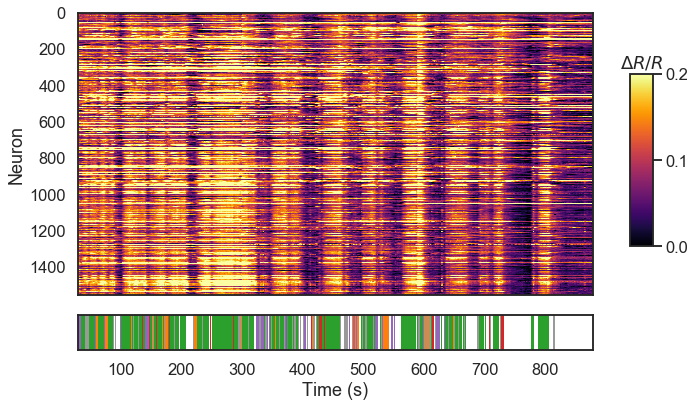

In [10]:
nf=2
reload(plotting)
exp_date = exp_list[nf][0]
fly_num = exp_list[nf][1]
expt_id = exp_list[nf][0] + '_' + exp_list[nf][1]
plotting.show_raster_with_behav(summary_dict_tot[nf]['data_dict'],color_range=(0,0.2),
                                title='',activity='nobase',sort=False,
                               include_beh_labels=True)
# plt.savefig(fig_dirs['fig_folder']+expt_id +'_residual_raster.pdf',transparent=False, bbox_inches='tight')
plt.show()

# correlation of smoothed behavior and mean dFF

In [6]:
def get_smooth_behav(data_dict, tau=1, nf=1):
    sigLimSec = 20
    sigLim = sigLimSec*data_dict['scanRate']
    M = np.round(-sigLim*np.log(0.1)).astype(int)
    t_exp = np.linspace(0, M/2, M)/data_dict['scanRate']

    kern = np.exp(-t_exp/tau)
    kern /= kern.sum()
    if nf>=2:
        ball = 1*(data_dict['beh_labels'][:,2]>0.5)
    else:
        ball = 1*(data_dict['behavior']>.0005)
    bs = np.convolve(kern,ball,'same')
    bs -= bs.mean()
    return bs, kern

def detrend(z, f=None):
    if f is not None:
        y = np.expand_dims(z-f,axis=1)
    else:
        y = np.expand_dims(z,axis=1)
    X = np.ones((len(z),2))
    X[:,1] = np.array([i for i in range(len(z))])
    #X[:,2] = np.array([i for i in range(len(z))])**2
    y = np.expand_dims(z,axis=1)
    a = np.linalg.inv(X.T@X)@X.T@y
    return np.squeeze(y-X@a)

In [7]:
c_max = np.zeros((2,len(exp_list)))
lag_max = np.zeros((2,len(exp_list)))
tau_val = 6

for nf in range(len(exp_list)):
    exp_date = exp_list[nf][0]
    fly_num = exp_list[nf][1]
    expt_id = exp_list[nf][0] + '_' + exp_list[nf][1]
    data_dict = data_tot[nf]['data_dict'] #summary_dict_tot[nf]['data_dict']

    beh_smooth, _ = get_smooth_behav(data_dict, tau=tau_val, nf=nf)
    beh_smooth-=beh_smooth.mean()
    beh_smooth/=beh_smooth.max()
    beh_smooth = detrend(beh_smooth)

    dFF_mean = data_dict['dYY'].mean(axis=0)
    dRR_mean = data_dict['dRR'].mean(axis=0)
    dFF_mean-=dFF_mean.mean()
    dRR_mean-=dRR_mean.mean()


    c = np.correlate(beh_smooth, dFF_mean, "same")/(len(beh_smooth)*beh_smooth.std()*dFF_mean.std())
    lags = np.linspace( -np.floor(len(c)/2), np.floor(len(c)/2), len(c) )/data_dict['scanRate']
    valid_range = (lags>-50)*(lags<50)
    c = c[valid_range]
    lags = lags[valid_range]
    c_max[0,nf] = c.max()
    lag_max[0,nf] = lags[np.argmax(c)]
    
    c = np.correlate(beh_smooth, dRR_mean, "same")/(len(beh_smooth)*beh_smooth.std()*dRR_mean.std())
    lags = np.linspace( -np.floor(len(c)/2), np.floor(len(c)/2), len(c) )/data_dict['scanRate']
    valid_range = (lags>-50)*(lags<0)
    c = c[valid_range]
    lags = lags[valid_range]
    c_max[1,nf] = c.max()
    lag_max[1,nf] = lags[np.argmax(c)]


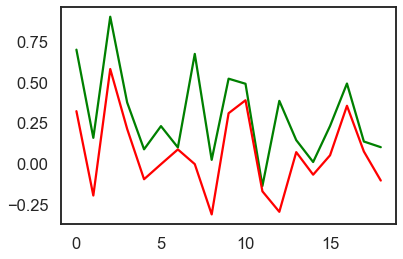

In [8]:
plt.plot(c_max[0,:],'g')
plt.plot(c_max[1,:],'r')

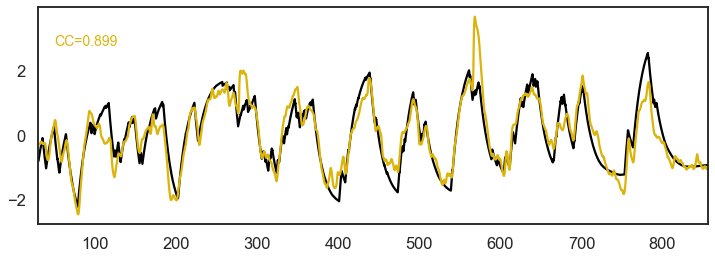

In [15]:
nf=2
reload(plotting)
exp_date = exp_list[nf][0]
fly_num = exp_list[nf][1]
expt_id = exp_list[nf][0] + '_' + exp_list[nf][1]
data_dict = data_tot[nf]['data_dict'] #summary_dict_tot[nf]['data_dict']

beh_smooth, _ = get_smooth_behav(data_dict, tau=tau_val, nf=nf)
# beh_smooth = detrend(beh_smooth)
beh_smooth-=beh_smooth.mean()
beh_smooth/=beh_smooth.max()

dFF_mean = data_dict['dFF'].mean(axis=0)
dFF_mean-=dFF_mean.mean()
dFF_mean/=dFF_mean.std()

dYY_mean = data_dict['dYY'].mean(axis=0)
dYY_mean-=dYY_mean.mean()
dYY_mean/=dYY_mean.std()

dRR_mean = data_dict['dRR'].mean(axis=0)
dRR_mean-=dRR_mean.mean()
dRR_mean/=dRR_mean.std()

l = lag_max[0,nf]
s = np.round(l*data_dict['scanRate']).astype(int)
# beh_plot = (beh_smooth[:s]-beh_smooth[:s].min())/(beh_smooth[:s].max()-beh_smooth[:s].min())
f_plot = dFF_mean[-s:] #(dFF_mean[-s:]-dFF_mean[-s:].min())/(dFF_mean[-s:].max()-dFF_mean[-s:].min())
f_plot = detrend(f_plot)


beh_plot = detrend(beh_smooth[:s],f_plot)
# beh_plot = (beh_plot-beh_plot.min())/(beh_plot.max()-beh_plot.min())
beh_plot/=beh_plot.std()

plt.figure(figsize=(12,4))
plt.plot(data_dict['tPl'][:s], beh_plot,color='k')
plt.plot(data_dict['tPl'][:s], f_plot,color='#dbb40c')
# plt.plot(dYY_mean[-s:],color='tab:green')

# plt.plot(beh_smooth,color='k')
# plt.plot(dFF_mean,color='gold')

# plt.plot(dYY_mean,color='tab:green')
# plt.plot(dRR_mean[-s:],color='tab:red')
plt.xlim(data_dict['tPl'][0],data_dict['tPl'][s])
plt.text(50,2.75,'CC='+str(round(np.corrcoef(beh_plot,f_plot)[0,1],3)),color='#dbb40c',fontsize=14)

fig_dirs = futils.get_fig_dirs(expt_id)
# plt.savefig(fig_dirs['regfig_folder']+expt_id +'_'+'dFF_run_mean_corr.pdf',transparent=True, bbox_inches='tight')
plt.show()


#### control: use motion metrics instead of running

Text(50, 2.75, 'CC=-0.016')

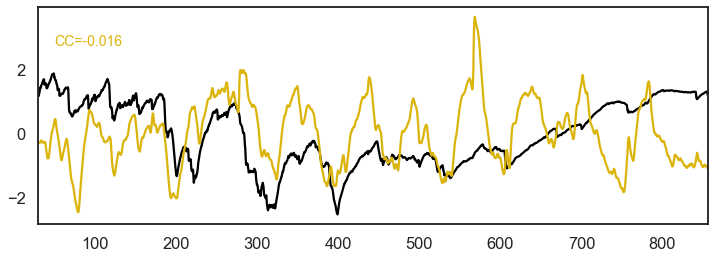

In [21]:
from scipy import io
import h5py
motion = io.loadmat('/Volumes/data1/scratchData/2019_07_01_Nsyb_NLS6s_walk/fly2/_matfiles/Yproj/motion_metrics.mat')
# motion = h5py.File('/Volumes/data1/scratchData/2019_07_01_Nsyb_NLS6s_walk/fly2/_matfiles/Yproj/motion_metrics.mat')
mm = motion['cR']

# reconstruct trimming done by source_process
time_full = data_dict['time'][0]+np.array([i for i in range(len(mm))])/data_dict['scanRate']
time_is_valid = np.array([False]*len(mm))
for i in np.unique(data_dict['trialFlag']):
    tr = np.flatnonzero(data_dict['trialFlag']==i)
    loc = np.argmin( abs(time_full-data_dict['time'][tr[0]]) )
    time_is_valid[loc:loc+len(tr)]=True

mm = np.squeeze(mm[time_is_valid])
mm = detrend(mm)

_, kern = get_smooth_behav(data_dict, tau=tau_val, nf=nf) #
mm_smooth = np.convolve(kern,mm,'same')
mm_smooth -= mm_smooth.mean()

mm_smooth_plot = detrend(mm_smooth[:s],f_plot)
mm_smooth_plot/=mm_smooth_plot.std()

plt.figure(figsize=(12,4))
plt.plot(data_dict['tPl'][:s], mm_smooth_plot,color='k')
plt.plot(data_dict['tPl'][:s], f_plot,color='#dbb40c')

plt.xlim(data_dict['tPl'][0],data_dict['tPl'][s])
plt.text(50,2.75,'CC='+str(round(np.corrcoef(mm_smooth_plot,f_plot)[0,1],3)),color='#dbb40c',fontsize=14)


Text(50, 2.75, 'CC=-0.016')

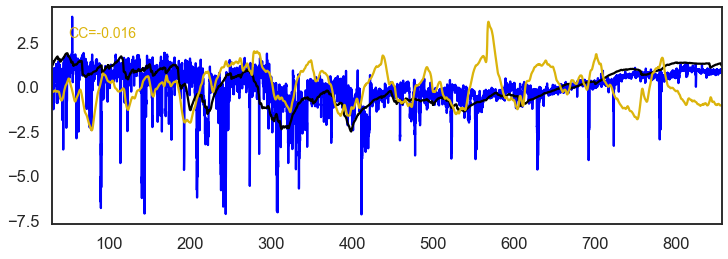

In [26]:
from scipy import io
import h5py
motion = io.loadmat('/Volumes/data1/scratchData/2019_07_01_Nsyb_NLS6s_walk/fly2/_matfiles/Yproj/motion_metrics.mat')
# motion = h5py.File('/Volumes/data1/scratchData/2019_07_01_Nsyb_NLS6s_walk/fly2/_matfiles/Yproj/motion_metrics.mat')
mm = motion['cR']

# reconstruct trimming done by source_process
time_full = data_dict['time'][0]+np.array([i for i in range(len(mm))])/data_dict['scanRate']
time_is_valid = np.array([False]*len(mm))
for i in np.unique(data_dict['trialFlag']):
    tr = np.flatnonzero(data_dict['trialFlag']==i)
    loc = np.argmin( abs(time_full-data_dict['time'][tr[0]]) )
    time_is_valid[loc:loc+len(tr)]=True

mm = np.squeeze(mm[time_is_valid])

# trim = 5000
# mm = mm[trim:]
# f_trimmed = f_plot[trim:]

mm = detrend(mm)
_, kern = get_smooth_behav(data_dict, tau=tau_val, nf=nf) #
mm_smooth = np.convolve(kern,mm,'same')
mm_smooth -= mm_smooth.mean()

mm_plot = detrend(mm[:s],f_plot)
mm_plot/=mm_plot.std()

mm_smooth_plot = detrend(mm_smooth[:s],f_plot)
mm_smooth_plot/=mm_smooth_plot.std()

plt.figure(figsize=(12,4))
plt.plot(data_dict['tPl'][:s], mm_plot,color='b')
plt.plot(data_dict['tPl'][:s], mm_smooth_plot,color='k')
plt.plot(data_dict['tPl'][:s], f_plot,color='#dbb40c')

plt.xlim(data_dict['tPl'][0],data_dict['tPl'][s])
plt.text(50,2.75,'CC='+str(round(np.corrcoef(mm_smooth_plot,f_plot)[0,1],3)),color='#dbb40c',fontsize=14)


Text(50, 2.75, 'CC=-0.09')

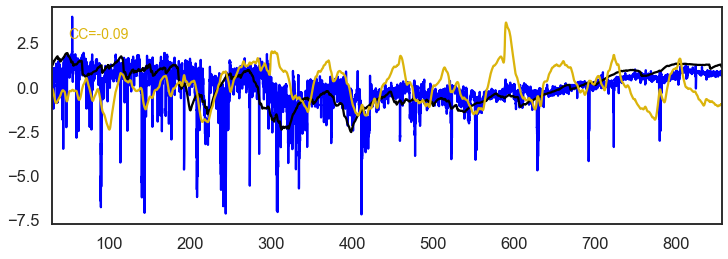

In [30]:
from scipy import io
import h5py
motion = io.loadmat('/Volumes/data1/scratchData/2019_07_01_Nsyb_NLS6s_walk/fly2/_matfiles/Yproj/motion_metrics.mat')
# motion = h5py.File('/Volumes/data1/scratchData/2019_07_01_Nsyb_NLS6s_walk/fly2/_matfiles/Yproj/motion_metrics.mat')
mm = motion['cR']

# reconstruct trimming done by source_process
time_full = data_dict['time'][0]+np.array([i for i in range(len(mm))])/data_dict['scanRate']
time_is_valid = np.array([False]*len(mm))
for i in np.unique(data_dict['trialFlag']):
    tr = np.flatnonzero(data_dict['trialFlag']==i)
    loc = np.argmin( abs(time_full-data_dict['time'][tr[0]]) )
    time_is_valid[loc:loc+len(tr)]=True

mm = np.squeeze(mm[time_is_valid])

mm = detrend(mm)
_, kern = get_smooth_behav(data_dict, tau=tau_val, nf=nf) #
mm_smooth = np.convolve(kern,mm,'same')
mm_smooth -= mm_smooth.mean()

f_plot_full = detrend(dFF_mean)
mm_plot = detrend(mm,f_plot_full)
mm_plot/=mm_plot.std()

mm_smooth_plot = detrend(mm_smooth,f_plot_full)
mm_smooth_plot/=mm_smooth_plot.std()

plt.figure(figsize=(12,4))
plt.plot(data_dict['tPl'], mm_plot,color='b')
plt.plot(data_dict['tPl'], mm_smooth_plot,color='k')
plt.plot(data_dict['tPl'], f_plot_full,color='#dbb40c')

plt.xlim(data_dict['tPl'][0],data_dict['tPl'][s])
plt.text(50,2.75,'CC='+str(round(np.corrcoef(mm_smooth_plot,f_plot_full)[0,1],3)),color='#dbb40c',fontsize=14)


# Behavior XCorr

In [13]:
lags_tot = []
c_tot = []
for nf in range(len(data_tot)):
    data_dict = summary_dict_tot[nf]['data_dict']

    mxlags=int(300*data_dict['scanRate'])
    t = np.linspace(0,300,300)
    # fit_long = .58*.7*np.exp(-t/5) + .58*.3*np.exp(-t/60) + .42*np.exp(-t/700)
    fit_long = .56*.7*np.exp(-t/5) + .56*.3*np.exp(-t/60) + .44*np.exp(-t/550)

    # plt.figure(figsize=(.1,.1))
    # lags, c, _, _ = plt.xcorr(data_dict['behavior'], data_dict['behavior'], usevlines=False, maxlags=mxlags, marker='.')
    # plt.gca().axis('off')
    
    if nf>1:
        beh = 1*(np.argmax(data_dict['beh_labels'],axis=1)==2)
        beh = beh-beh.mean()
    else:
        beh = data_dict['behavior'] - data_dict['behavior'].mean()
        
    c = np.correlate(beh, beh, "same")/(len(beh)*beh.var())
    if len(c)%2 == 0:
        lags = np.linspace( -np.floor(len(c)/2)+1, np.floor(len(c)/2), len(c) )/data_dict['scanRate']
    else:
        lags = np.linspace( -np.floor(len(c)/2), np.floor(len(c)/2), len(c) )/data_dict['scanRate']
    
    c_tot.append(c)
    lags_tot.append(lags)
    

In [23]:
# bin autocorrelations from all flies to be on same points
bins = np.linspace(-300,301,602)
c_binned = np.zeros((len(c_tot),len(bins)))
for nf in range(len(c_tot)):
    l = lags_tot[nf]
    for i in range(len(bins)-1):
        c_binned[nf,i] = c_tot[nf][ (bins[i]<l)*(l<bins[i+1]) ].mean()
    c_binned[nf,300] = 1
    
c_mean = c_binned.mean(axis=0)
c_std = c_binned.std(axis=0)/np.sqrt(c_binned.shape[0])

/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [24]:
bins[300]

0.0

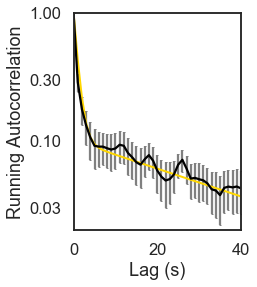

In [26]:
import matplotlib

plt.figure(figsize=(3,4))
ax1 = plt.axes()
ax1.errorbar(bins, c_mean, yerr=c_std,color='k',ecolor='gray',capsize=1)
ax1.set_xlim(1,40)
ax1.set_ylim(0.02,1)
# ax1.set_yticks([.25,.5,.75,1])
ax1.set_yscale('log')
# ax1.set_xscale('log')
# xticklabels = np.array([-300,-150,0,150,300])
# xticklocs = xticklabels #*data_dict['scanRate']
# plt.xticks(ticks=xticklocs, labels=xticklabels)
ax1.set_xlabel('Lag (s)')
ax1.set_ylabel('Running Autocorrelation')
ax1.set_xticks([0,20,40])
ax1.set_yticks([.03,.1,.3,1])
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


f1=.9
fit_long = f1*np.exp(-t/1) + (1-f1)*np.exp(-t/40)
ax1.plot(t,fit_long, linewidth=2, color='gold' )
plt.savefig(dirs['results']+'_summary/regression/behav_autocorr.pdf',transparent=True, bbox_inches='tight')
plt.show()

### and for grooming

In [96]:
lags_tot_bf = []
c_tot_f = []
c_tot_b = []
for nf in range(2,len(data_tot)):
    data_dict = summary_dict_tot[nf]['data_dict']

    mxlags=int(300*data_dict['scanRate'])
    t = np.linspace(0,300,300)
    # fit_long = .58*.7*np.exp(-t/5) + .58*.3*np.exp(-t/60) + .42*np.exp(-t/700)
    fit_long = .56*.7*np.exp(-t/5) + .56*.3*np.exp(-t/60) + .44*np.exp(-t/550)

    # plt.figure(figsize=(.1,.1))
    # lags, c, _, _ = plt.xcorr(data_dict['behavior'], data_dict['behavior'], usevlines=False, maxlags=mxlags, marker='.')
    # plt.gca().axis('off')
    
    beh_f = 1*(np.argmax(data_dict['beh_labels'],axis=1)==3)
    beh_f = beh_f-beh_f.mean()
    beh_b = 1*(np.argmax(data_dict['beh_labels'],axis=1)==4)
    beh_b = beh_b-beh_b.mean()
    
    c = np.correlate(beh_f, beh_f, "same")/(len(beh_f)*beh_f.var())
    if len(c)%2 == 0:
        lags = np.linspace( -np.floor(len(c)/2)+1, np.floor(len(c)/2), len(c) )/data_dict['scanRate']
    else:
        lags = np.linspace( -np.floor(len(c)/2), np.floor(len(c)/2), len(c) )/data_dict['scanRate']
    c_tot_f.append(c)
    lags_tot_bf.append(lags)
    
    c = np.correlate(beh_b, beh_b, "same")/(len(beh_b)*beh_b.var())
    c_tot_b.append(c)
    

In [97]:
# bin autocorrelations from all flies to be on same points
bins = np.linspace(-300,301,602)
c_binned_f = np.zeros((len(c_tot_f),len(bins)))
c_binned_b = np.zeros((len(c_tot_b),len(bins)))
for nf in range(len(c_tot_f)):
    l = lags_tot_bf[nf]
    for i in range(len(bins)-1):
        c_binned_f[nf,i] = c_tot_f[nf][ (bins[i]<l)*(l<bins[i+1]) ].mean()
        c_binned_b[nf,i] = c_tot_b[nf][ (bins[i]<l)*(l<bins[i+1]) ].mean()
    c_binned_f[nf,301] = 1
    c_binned_b[nf,301] = 1
    
cf_mean = c_binned_f.mean(axis=0)
cf_std = c_binned_f.std(axis=0)/np.sqrt(c_binned_f.shape[0])
cb_mean = c_binned_b.mean(axis=0)
cb_std = c_binned_b.std(axis=0)/np.sqrt(c_binned_b.shape[0])

/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice.
  if __name__ == '__main__':


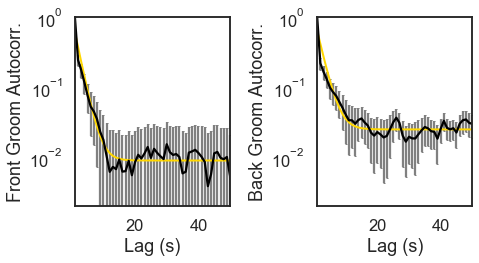

In [126]:
plt.figure(figsize=(7,4))
ax1 = plt.subplot(121)
ax1.errorbar(bins, cf_mean, yerr=cf_std,color='k',ecolor='gray',capsize=1)
ax1.set_xlim(1,50)
ax1.set_ylim(0.002,1)
ax1.set_yticks([.25,.5,.75,1])
ax1.set_yscale('log')
# ax1.set_xscale('log')
# xticklabels = np.array([-300,-150,0,150,300])
# xticklocs = xticklabels #*data_dict['scanRate']
# plt.xticks(ticks=xticklocs, labels=xticklabels)
ax1.set_xlabel('Lag (s)')
ax1.set_ylabel('Front Groom Autocorr.')
f1=.991
fit_long = f1*np.exp(-t/2) + (1-f1) #(1-f1)*np.exp(-t/240)
ax1.plot(t,fit_long, linewidth=2, color='gold' )

ax1 = plt.subplot(122)
ax1.errorbar(bins, cb_mean, yerr=cb_std,color='k',ecolor='gray',capsize=1)
ax1.set_xlim(1,50)
ax1.set_ylim(0.002,1)
ax1.set_yticks([.25,.5,.75,1])
ax1.set_yscale('log')
# ax1.set_xscale('log')
# xticklabels = np.array([-300,-150,0,150,300])
# xticklocs = xticklabels #*data_dict['scanRate']
# plt.xticks(ticks=xticklocs, labels=xticklabels)
ax1.set_xlabel('Lag (s)')
ax1.set_ylabel('Back Groom Autocorr.')
f1=.975
fit_long = f1*np.exp(-t/2.2) + (1-f1) #*np.exp(-t/100)
ax1.plot(t,fit_long, linewidth=2, color='gold' )

plt.tight_layout()
plt.savefig(dirs['results']+'_summary/regression/behav_autocorr_fbgroom.pdf',transparent=True, bbox_inches='tight')
plt.show()

# XCorr between dF/F and behavior

In [141]:
nf=2
data_dict = summary_dict_tot[nf]['data_dict'] #data_tot[nf]['data_dict']

In [144]:
data_dict['behavior'].shape, data_dict['dFF'].shape

((5110,), (1559, 5110))

In [155]:
mxlags = 60
N = data_dict['dFF'].shape[0]
c_max = np.zeros((N,2))
b = 1*(np.argmax(data_dict['beh_labels'],axis=1)==2) #data_dict['behavior']-data_dict['behavior'].mean()
b = b-b.mean()
x = np.linspace(-.5*len(b)/data_dict['scanRate'],.5*len(b)/data_dict['scanRate'],len(b))
valid = (-mxlags<x)*(x<mxlags)
for n in range(N):
    f = data_dict['dFF'][n,:].copy()
    c = np.correlate(f-f.mean(), b, "same")/(f.std()*b.std()*len(f))
    c_max[n,:] = [x[valid][np.argmax(c[valid])], c[valid].max()]

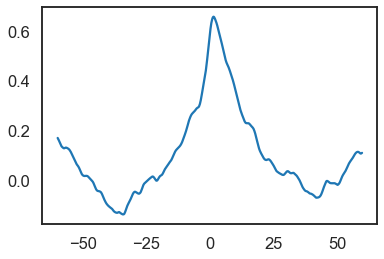

In [156]:
plt.plot(x[valid],c[valid])

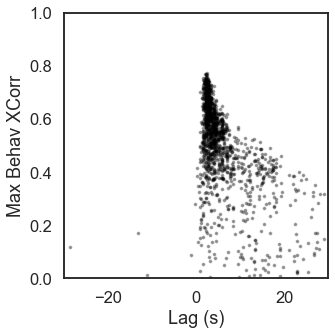

In [158]:
plt.figure(figsize=(5,5))
# plt.subplot(121)
plt.scatter(c_max[:,0],c_max[:,1],s=5, color='k', alpha=0.3)
# plt.scatter(c_max[408,0],c_max[408,1],s=5, color='r')
plt.xlabel('Lag (s)')
plt.ylabel('Max Behav XCorr')
# plt.xlim(-60,60)
# plt.subplot(122)
# plt.scatter(c_max[:,0],c_max[:,1],s=5, color='k', alpha=0.3)
# plt.xlabel('Lag (s)')
plt.xlim(-30,30)
plt.ylim(0,1)
plt.tight_layout()
expt_id = exp_list[nf][0] + '_' + exp_list[nf][1]
# plt.savefig(dirs['results']+'_summary/regression/cell_xcorr_'+expt_id+'.pdf',transparent=True, bbox_inches='tight')
plt.show()

In [159]:
model_retrofit = []
for i in range(c_max.shape[0]):
    model_retrofit.append( {'Lag (s)':c_max[i,0], 'Max Behav XCorr':c_max[i,1]} )
    model_retrofit[i]['r_sq'] = {'Lag (s)':c_max[i,0], 'Max Behav XCorr':c_max[i,1]}
    model_retrofit[i]['cc'] = {'Lag (s)':c_max[i,0], 'Max Behav XCorr':c_max[i,1]}
    model_retrofit[i]['stat'] = {'Lag (s)':[[0,1]], 'Max Behav XCorr':[[0,1]]}

> /Users/evan/Dropbox/_code/flygenvectors/flygenvectors/plotting.py(1366)show_param_scatter()
-> if xlim is None:
(Pdb) cl
Clear all breaks? y
Deleted breakpoint 1 at /Users/evan/Dropbox/_code/flygenvectors/flygenvectors/plotting.py:1366
Deleted breakpoint 2 at /Users/evan/Dropbox/_code/flygenvectors/flygenvectors/plotting.py:1408
(Pdb) c


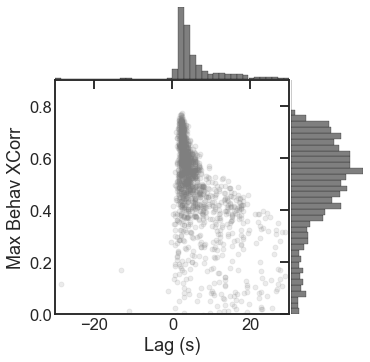

In [166]:
# make composite scatter
# import pdb
reload(plotting)
# pdb.set_trace()
# param_label = param[0]+'_'+str(param[1])+param2[0]+'_'+str(param2[1])
plotting.show_param_scatter(model_retrofit, None, 'Lag (s)', param2_input='Max Behav XCorr', 
                            xlim=[-30,30], ylim=[0,.9], omit_last_bin=False)
plt.savefig(dirs['results']+'_summary/regression/cell_xcorr_'+expt_id+'_wHist.pdf',transparent=True, bbox_inches='tight')


# Power spectrum of dF/F

In [21]:
grid_points = 128
mx_tmp = np.zeros((len(data_tot),3))
for nf in range(len(exp_list)):
    mx_tmp[nf,:] = data_tot[nf]['data_dict']['aligned_centroids'].max(axis=0)
mx = mx_tmp.max(axis=0)

grid_image_2d_tot = []
grid_image_ctrl_2d_tot = []
powerx_2d_tot = []
powerx_ctrl_2d_tot = []
for nf in range(len(exp_list)):
    data_dict = data_tot[nf]['data_dict']
    dFF_mean = data_dict['dFF'].mean(axis=0)
    N = data_tot[nf]['data_dict']['aligned_centroids'].shape[0]
    
    grid_image_2d = np.zeros((grid_points,data_dict['dFF'].shape[1]))
    grid_image_ctrl_2d = np.zeros((grid_points,data_dict['dFF'].shape[1]))
    for n in range(N):
        if(np.mod(n,200)==0): print(n,end=' ')
        x,y,z = np.round(grid_points*(data_dict['aligned_centroids'][n,:]/mx)).astype(int)-1
        grid_image_2d[y,:] += data_dict['dFF'][n,:] 
        grid_image_ctrl_2d[y,:] += dFF_mean  
    
    grid_image_2d_tot.append(grid_image_2d)
    grid_image_ctrl_2d_tot.append(grid_image_ctrl_2d)
    
    out_2d = np.fft.rfft2(grid_image_2d)
    out_ctrl_2d = np.fft.rfft2(grid_image_ctrl_2d)
    power_2d = np.abs(out_2d)**2
    power_ctrl_2d = np.abs(out_ctrl_2d)**2

    powerx_2d = np.fft.fftshift( power_2d.max(axis=1) )
    powerx_ctrl_2d = np.fft.fftshift( power_ctrl_2d.max(axis=1) )
    powerx_2d_tot.append(powerx_2d)
    powerx_ctrl_2d_tot.append(powerx_ctrl_2d)

0 200 400 600 800 1000 1200 1400 1600 1800 0 200 400 600 800 1000 1200 1400 1600 1800 2000 2200 0 200 400 600 800 1000 1200 0 200 400 600 800 1000 1200 1400 1600 0 200 400 600 800 1000 1200 0 200 400 600 0 200 400 600 800 1000 0 200 400 600 800 1000 1200 1400 1600 0 200 400 600 800 1000 1200 1400 

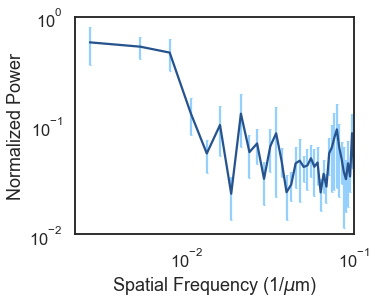

In [31]:
import matplotlib.ticker as ticker

freqs = np.fft.fftshift( np.fft.fftfreq(powerx_2d.shape[0]) )
fscale = grid_points/data_dict['dims_in_um'][1]

plt.figure(figsize=(5,4))
ax1 = plt.axes()
# ax1.plot(freqs, powerx_shapectrl,'--' )
# ax1.plot(freqs, powerx_ctrl )
exp_for_plot = [i for i in range(len(exp_list))] #
plot_power = np.zeros((len(exp_for_plot), powerx_2d_tot[0][freqs>0].shape[0]))
for nf in enumerate(exp_for_plot):
    plot_power[nf[0]] = (powerx_2d_tot[nf[1]]-powerx_ctrl_2d_tot[nf[1]])[freqs>0]
    plot_power[nf[0]] /= plot_power[nf[0]].max()

power_mean = plot_power.mean(axis=0)
power_std = plot_power.std(axis=0)/np.sqrt(plot_power.shape[0])
#plot_power = (powerx_2d_tot[nf]-powerx_ctrl_2d_tot[nf])[freqs>0]
ax1.errorbar(freqs[freqs>0]*fscale, power_mean, yerr=power_std,color='#26538d',ecolor='#95d0fc',capsize=1)
# ax1.plot(freqs[freqs>0]*fscale, power_mean)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel(r'Spatial Frequency (1/$\mu$m)')
ax1.set_ylabel('Normalized Power')
ax1.set_ylim(1e-2,1e0)
l = ax1.get_xlim()
ax1.set_xlim(l[0],0.1) #freqs.max()*fscale)
# ax1.set_xlim(2e-3,1e-1) #freqs.max()*fscale)
# ax1.set_xticks([.003,.01,.03,.1])

# ax1.xaxis.grid(True, which='minor')
# ax1.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
# ax1.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, numticks=10))

# expt_id = exp_list[nf][0] + '_' + exp_list[nf][1]
# fig_dirs = futils.get_fig_dirs(expt_id)
# plt.savefig(dirs['results']+'_summary/lateral_power_spectrum.pdf',transparent=True, bbox_inches='tight')
    
plt.show()
# STOPPED HERE.  JUST FIX HORIZONTAL AXIS TO BE IN MEANINGFUL FREQUENCY (1/UM INSTEAD OF 1/PX?)
# is lower bound here because of "max" operation? (test in simple sinusoidal case)

In [60]:
# downsample plotted frequencies to approximately even spacing

pos_freqs = freqs[freqs>0]*fscale

query_pts = np.geomspace(start=pos_freqs[10], stop=0.1, num=10)[1:]
query_idxs = np.zeros(len(query_pts),dtype=int)
for i in range(len(query_pts)):
    query_idxs[i] = np.argmin(abs(pos_freqs-query_pts[i]))
    
plot_idxs = [i for i in range(11)]
plot_idxs.extend(query_idxs.tolist())

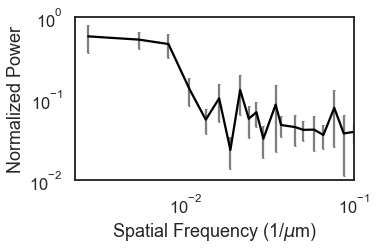

In [68]:
plt.figure(figsize=(5,3))
ax1 = plt.axes()

ax1.errorbar(pos_freqs[plot_idxs], power_mean[plot_idxs], yerr=power_std[plot_idxs],color='k',ecolor='#7d7f7c',capsize=1)
# ax1.plot(freqs[freqs>0]*fscale, power_mean)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel(r'Spatial Frequency (1/$\mu$m)')
ax1.set_ylabel('Normalized Power')
ax1.set_ylim(1e-2,1e0)
l = ax1.get_xlim()
ax1.set_xlim(l[0],0.1) #freqs.max()*fscale)
plt.savefig(dirs['results']+'_summary/lateral_power_spectrum_log.pdf',transparent=True, bbox_inches='tight')    
plt.show()


In [72]:
1/pos_freqs[plot_idxs][4]

75.88060670183532

## FFT SANDBOX

In [6]:
grid_image = np.zeros((grid_points,grid_points,grid_points,data_dict['dFF'].shape[1]))
grid_image_ctrl = np.zeros((grid_points,grid_points,grid_points,data_dict['dFF'].shape[1]))
grid_image_shapectrl = np.zeros((grid_points,grid_points,grid_points,1))
dFF_mean = data_dict['dFF'].mean(axis=0)
grid_image_shapectrl = grid_image_shapectrl@np.expand_dims(dFF_mean,axis=0)
for n in range(N):
    if(np.mod(n,200)==0): print(n,end=' ')
    x,y,z = np.round(grid_points*(data_dict['aligned_centroids'][n,:]/mx)).astype(int)-1
    grid_image[x,y,z,:] += data_dict['dFF'][n,:] 
    grid_image_ctrl[x,y,z,:] += dFF_mean  


0 200 400 600 800 1000 1200 1400 1600 1800 2000 

In [8]:
out = np.fft.rfftn(grid_image)
out_ctrl = np.fft.rfftn(grid_image_ctrl)
out_shapectrl = np.fft.rfftn(grid_image_shapectrl)

In [10]:
power = np.abs(out)**2
power_ctrl = np.abs(out_ctrl)**2
power_shapectrl = np.abs(out_shapectrl)**2

In [30]:
powerx = np.fft.fftshift( power.max(axis=3).max(axis=2).max(axis=0) )
powerx_ctrl = np.fft.fftshift( power_ctrl.max(axis=3).max(axis=2).max(axis=0) )
powerx_shapectrl = np.fft.fftshift( power_shapectrl.max(axis=3).max(axis=2).max(axis=0) )

In [21]:
powert = np.fft.fftshift( power.max(axis=2).max(axis=1).max(axis=0) )
powert_ctrl = np.fft.fftshift( power_ctrl.max(axis=2).max(axis=1).max(axis=0) )
powert_shapectrl = np.fft.fftshift( power_shapectrl.max(axis=2).max(axis=1).max(axis=0) )

In [31]:
freqs = np.fft.fftshift( np.fft.fftfreq(powerx.shape[0]) )

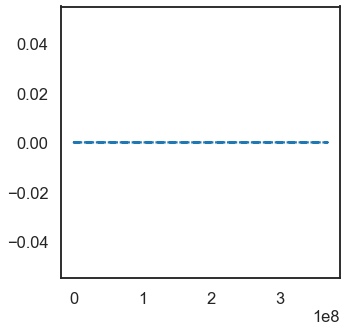

In [24]:
freqst = np.fft.fftshift( np.fft.fftfreq(powert.shape[0]) )
plt.figure(figsize=(5,5))
ax1 = plt.axes()
ax1.plot(powert, powert_shapectrl,'--' )
# ax1.plot(freqst, powert_ctrl )
# ax1.plot(freqst, powert)

In [44]:
nf

0

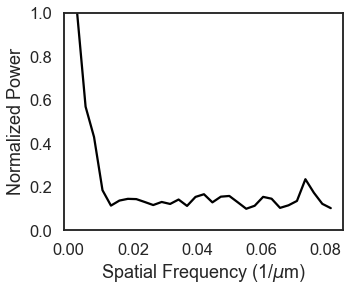

In [46]:
N = 64
M = data_dict['dims_in_um'][1]

plt.figure(figsize=(5,4))
ax1 = plt.axes()
# ax1.plot(freqs, powerx_shapectrl,'--' )
# ax1.plot(freqs, powerx_ctrl )
plot_power = (powerx-powerx_ctrl)[freqs>0]
ax1.plot(freqs[freqs>0]*N/M, plot_power/plot_power.max(),'k' )
# ax1.set_yscale('log')
ax1.set_xlabel(r'Spatial Frequency (1/$\mu$m)')
ax1.set_ylabel('Normalized Power')
ax1.set_ylim(0,1)

expt_id = exp_list[nf][0] + '_' + exp_list[nf][1]
fig_dirs = futils.get_fig_dirs(expt_id)
plt.savefig(fig_dirs['regfig_folder']+expt_id +'_'+'lateral_power_spectrum.pdf',transparent=True, bbox_inches='tight')
    
plt.show()
# STOPPED HERE.  JUST FIX HORIZONTAL AXIS TO BE IN MEANINGFUL FREQUENCY (1/UM INSTEAD OF 1/PX?)
# is lower bound here because of "max" operation? (test in simple sinusoidal case)

In [39]:
1/.01

100.0

(-2, 2)

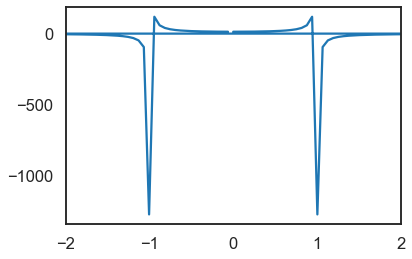

In [17]:
N=10000
M=100
t = np.linspace(0,M,N)
sp = np.fft.fft(np.sin(t))
freq = np.fft.fftfreq(t.shape[-1])
plt.plot(freq*N/M*2*np.pi, sp.real)
plt.xlim(-2,2)

In [18]:
sp.real[:4], sp.real[-4:]

(array([13.51343839, 13.56600229, 13.7262236 , 14.0020017 ]),
 array([14.40761075, 14.0020017 , 13.7262236 , 13.56600229]))

In [20]:
(np.abs(sp)**2)[:4], (np.abs(sp)**2)[-4:]

(array([182.61301721, 193.8899584 , 228.7774641 , 290.63970736]),
 array([385.79217447, 290.63970736, 228.7774641 , 193.8899584 ]))

In [41]:
outxy = out.max(axis=3).max(axis=2)
outxz = out.max(axis=3).max(axis=1)
outyz = out.max(axis=3).max(axis=0)

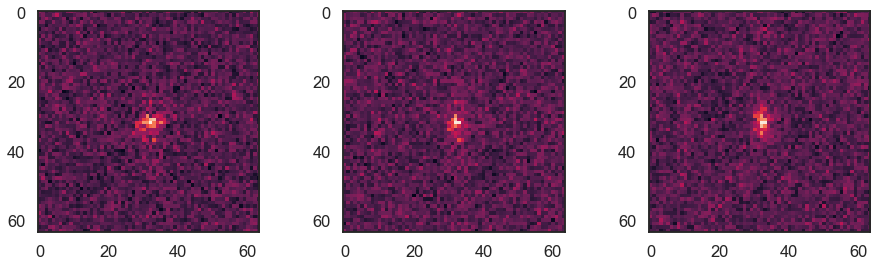

In [43]:
plt.figure(figsize=(13,4))
plt.subplot(131)
plt.imshow(np.log(np.abs(np.fft.fftshift(outxy))**2))
plt.subplot(132)
plt.imshow(np.log(np.abs(np.fft.fftshift(outxz))**2))
plt.subplot(133)
plt.imshow(np.log(np.abs(np.fft.fftshift(outyz))**2))
plt.tight_layout()
plt.show()

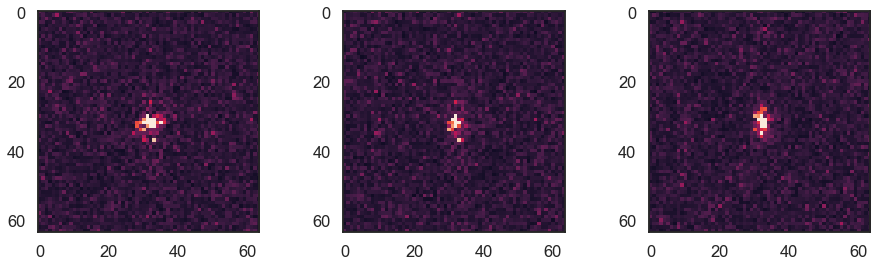

In [49]:
cmin = 1e1
cmax = 2e7
plt.figure(figsize=(13,4))
plt.subplot(131)
plt.imshow(np.abs(np.fft.fftshift(outxy))**2)
plt.clim(cmin, cmax)
plt.subplot(132)
plt.imshow(np.abs(np.fft.fftshift(outxz))**2)
plt.clim(cmin, cmax)
plt.subplot(133)
plt.imshow(np.abs(np.fft.fftshift(outyz))**2)
plt.clim(cmin, cmax)
plt.tight_layout()
plt.show()

In [22]:
out0.shape

(50, 50, 50, 3435)

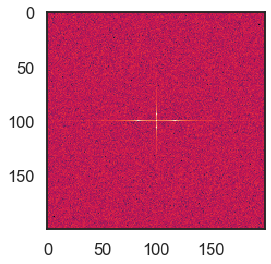

In [11]:
[X, Y] = np.meshgrid(2 * np.pi * np.arange(200) / 12,
                     2 * np.pi * np.arange(200) / 34)
S = np.sin(X) + np.cos(Y) + np.random.uniform(0, 1, X.shape)
FS = np.fft.fftn(S)
plt.imshow(np.log(np.abs(np.fft.fftshift(FS))**2))
plt.show()

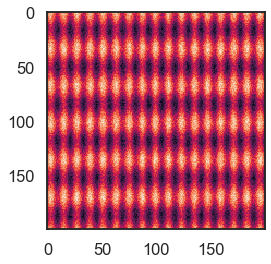

In [12]:
plt.imshow(S)